In [35]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
from sklearn.decomposition import PCA
import numpy as np
import time, math, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'

sys.path.insert(1, '/home/joeadamo/Research/CovNet')
#sys.path.insert(1, '/home/jadamo/CovA-NN-Emulator')
import CovNet

In [2]:
# IMPORTANT: Make sure the parameters here are the same as when you trained the network in question!
N = 49500
N_test = int(N*0.1)
train_log = True
train_correlation = False
train_cholesky = False
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-NG/"
#training_dir = "/home/jadamo/CovNet/Data/Training-Set/"
save_dir = "/home/joeadamo/Research/CovNet/Plots/"
#save_dir = "/home/jadamo//CovNet/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
#BOSS_dir = "/home/jadamo/CovNet/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"
#CovaPT_dir = "/home/jadamo/CovaPT/Example-Data/"
net_dir = "../Data/Non-Gaussian/"

k =np.loadtxt(CovaPT_dir+'k_Patchy.dat')
#TODO: The k-bins between these 2 spectra aren't exactly the same, should I try interpolating?
#xi_hat = np.concatenate((P_BOSS[1], P_BOSS[2]))
#xi_pi = np.concatenate((P0_mean, P2_mean))
#x = torch.from_numpy(xi_hat - xi_pi).to(CovNet.try_gpu()).float()

F_loss = nn.L1Loss()

In [25]:
# load the trained network
#net = CovNet.Network_Full(6, 100*100)
net = CovNet.Network_VAE(train_cholesky).to(CovNet.try_gpu());       net.eval()
encoder = CovNet.Block_Encoder().to(CovNet.try_gpu()); encoder.eval()
decoder = CovNet.Block_Decoder(train_cholesky).to(CovNet.try_gpu()); decoder.eval()
net_2 = CovNet.Network_Features(6, 10).to(CovNet.try_gpu())
net.load_state_dict(torch.load(net_dir+'network-VAE.params'))
encoder.load_state_dict(net.Encoder.state_dict())
decoder.load_state_dict(net.Decoder.state_dict())
net_2.load_state_dict(torch.load(net_dir+'network-features.params'))

<All keys matched successfully>

In [24]:
# load the test set
t1 = time.time()
test_data = CovNet.MatrixDataset(training_dir, N_test, int(N*0.9), train_log, train_correlation, train_cholesky)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 3.37 s


In [11]:
# test the matrix -> features -> matrix pipeline
t1 = time.time()
loss_data = np.zeros(N_test)
chi_min = 1000000; chi_max = 0; chi_avg = 0.
num_bad = 0; avg_bad = 0;
net.eval()
for (i, batch) in enumerate(test_loader):
    params = batch[0]; matrix = batch[1]
    prediction, mu, log_var = net(matrix.view(1, 100, 100))
    prediction = prediction.view(100,100); matrix = matrix.view(100,100)
    #loss = F_loss(prediction, matrix)
    loss = CovNet.VAE_loss(prediction, matrix, mu, log_var)
    loss_data[i] = loss.item()
    if train_cholesky or train_correlation:
        if train_cholesky:
            prediction = torch.matmul(CovNet.symmetric_exp(prediction), torch.t(CovNet.symmetric_exp(prediction)))
            matrix = torch.matmul(CovNet.symmetric_exp(matrix), torch.t(CovNet.symmetric_exp(matrix)))
        elif train_correlation:
            prediction = CovNet.corr_to_cov(prediction)
            matrix = CovNet.corr_to_cov(matrix)
        perc_predict = torch.linalg.inv(prediction.detach()); perc_predict = perc_predict.view(100,100)
        perc_actual  = torch.linalg.inv(matrix.detach()); perc_actual = perc_actual.view(100,100)
    else:
        perc_predict = torch.linalg.inv(CovNet.symmetric_exp(prediction.detach())); perc_predict = perc_predict.view(100,100)
        perc_actual  = torch.linalg.inv(CovNet.symmetric_exp(matrix.detach())); perc_actual = perc_actual.view(100,100)
    #chi_squared_1 = torch.matmul(torch.t(x), torch.matmul(perc_predict, x))
    #chi_squared_2 = torch.matmul(torch.t(x), torch.matmul(perc_actual, x))
    #chi_min = min(chi_min, abs(chi_squared_1 - chi_squared_2)); chi_max = max(chi_max, abs(chi_squared_1 - chi_squared_2)); chi_avg += abs(chi_squared_1 - chi_squared_2)
    
    eigen, v = torch.linalg.eigh(CovNet.symmetric_exp(prediction))
    if torch.all(eigen > 0.) == False:
        num_bad += 1
        avg_bad += len(eigen[(eigen < 0)])
    
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print("min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data), np.amax(loss_data), np.sum(loss_data) / N_test))
#print("chi squared absolute errors: [{:0.2f}, {:0.2f}], avg = {:0.3f}".format(chi_min, chi_max, chi_avg / N_test))
if num_bad != 0:
    print(num_bad, "matrices have negative eigenvalues!, average number of negative eigenvalues =", 1.*avg_bad / num_bad)

Done!, took 0 minutes 28.66 seconds
min loss: 681.399, max loss 8259.870, avg loss: 3257.854
4950 matrices have negative eigenvalues!, average number of negative eigenvalues = 54.7989898989899


Text(0, 0.5, 'N')

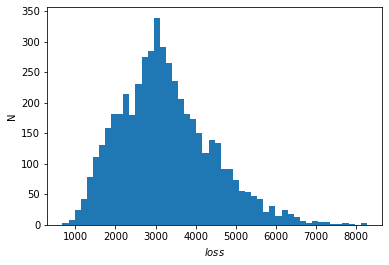

In [12]:
plt.hist(loss_data, bins=50)#bins=np.logspace(np.log10(np.amin(loss_data)), np.log10(np.amax(loss_data)), 50))
plt.xlabel(r"$loss$")
plt.ylabel("N")
#plt.xscale("log")

In [30]:
# test the params -> features -> matrix pipeline
chi_min = 1000000; chi_max = 0; chi_avg = 0.
num_bad = 0; avg_bad = 0;
loss_data = np.zeros(N_test)
errors = torch.zeros(N_test)
t1 = time.time()
for (i, batch) in enumerate(test_loader):
    params = batch[0]; matrix = batch[1]
    features = net_2(params); prediction = decoder(features.view(1,10)).view(100, 100)
    matrix = matrix.view(100,100)
    
    if train_cholesky or train_correlation:
        if train_cholesky:
            prediction = torch.matmul(CovNet.symmetric_exp(prediction), torch.t(CovNet.symmetric_exp(prediction)))
            matrix = torch.matmul(CovNet.symmetric_exp(matrix), torch.t(CovNet.symmetric_exp(matrix)))
        elif train_correlation:
            prediction = CovNet.corr_to_cov(prediction)
            matrix = CovNet.corr_to_cov(matrix)
        perc_predict = torch.linalg.inv(prediction.detach()); perc_predict = perc_predict.view(100,100)
        perc_actual  = torch.linalg.inv(matrix.detach()); perc_actual = perc_actual.view(100,100)
    else:
        perc_predict = torch.linalg.inv(CovNet.symmetric_exp(prediction.detach())); perc_predict = perc_predict.view(100,100)
        perc_actual  = torch.linalg.inv(CovNet.symmetric_exp(matrix.detach())); perc_actual = perc_actual.view(100,100)
        
    #chi_squared_1 = torch.matmul(torch.t(x), torch.matmul(perc_predict, x))
    #chi_squared_2 = torch.matmul(torch.t(x), torch.matmul(perc_actual, x))
    #chi_err = abs(chi_squared_1 - chi_squared_2)
    #errors[i] = chi_err
    #chi_min = min(chi_min, chi_err); chi_max = max(chi_max, chi_err); chi_avg += chi_err
    eigen, v = torch.linalg.eigh(CovNet.symmetric_exp(prediction))
    if torch.all(eigen > 0.) == False:
        num_bad += 1
        avg_bad += len(torch.where(eigen < 0))
    
#errors = errors.to("cpu").detach().numpy()
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
#print("chi squared absolute errors: [{:0.2f}, {:0.2f}], avg = {:0.3f}".format(chi_min, chi_max, chi_avg / N_test))
if num_bad != 0:
    print(num_bad, "matrices have negative eigenvalues!, average number of negative eigenvalues =", 1.*avg_bad / num_bad)

Done!, took 0 minutes 40.06 seconds
4950 matrices have negative eigenvalues!, average number of negative eigenvalues = 1.0


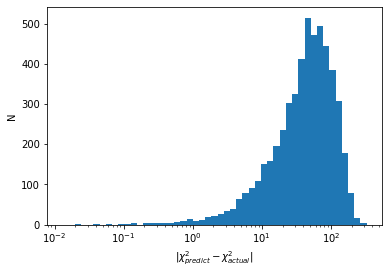

In [28]:
plt.hist(errors, bins=np.logspace(np.log10(np.amin(errors)), np.log10(np.amax(errors)), 50))
plt.xlabel(r"$|\chi_{predict}^2 - \chi_{actual}^2|$")
plt.ylabel("N")
plt.xscale("log")

Indexes: 3385 2568


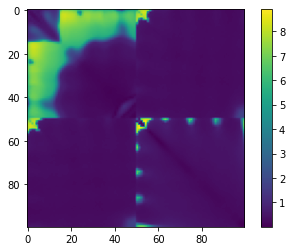

In [26]:
# Let's first test that seperate parameter imputs give different outputs
idx1 = np.random.randint(0, N_test); idx2 = np.random.randint(0, N_test)
params1 = test_data[idx1][0]; params2 = test_data[idx2][0]
cov_actual1 = test_data[idx1][1]; cov_actual2 = test_data[idx2][1]

features = net_2(params1); cov_predict1 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()
features = net_2(params2); cov_predict2 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:", idx1, idx2)
plt.imshow(abs(cov_predict1 - cov_predict2))
cbar = plt.colorbar()

loss =  2813.16455078125
rediction = 2578.987, KL Divergence = 234.178
sample 3853, params: tensor([ 6.8446e+01,  1.1429e-01,  2.1550e-02,  2.7743e+00,  2.4089e+00,
        -2.3319e+00])


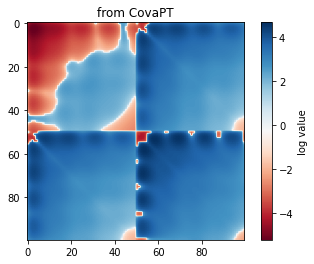

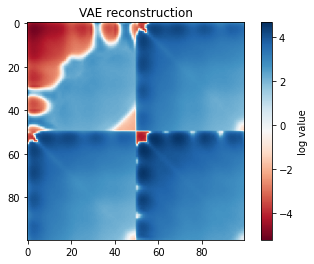

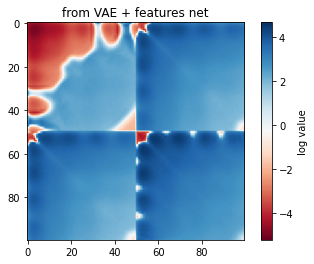

In [29]:
# Let's do some more detailed analysis on a random matrix from the test set
idx = np.random.randint(0, N_test)
params = test_data[idx][0]
# matrix from CovaPT
cov_actual = test_data[idx][1]
# matrix from VAE reconstruction
cov_VAE, mu, log_var = net(cov_actual.view(1,100,100)); cov_VAE = cov_VAE.view(100,100)
# matrix from parameters -> features and features -> matrix
features = net_2(params); cov_predict = decoder(features.view(1,10)).view(100, 100)

RLoss = F.l1_loss(cov_VAE, cov_actual, reduction="sum")
KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2))

print("loss = ", CovNet.VAE_loss(cov_VAE, cov_actual, mu, log_var).item())
print("rediction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
cov_VAE = cov_VAE.to("cpu").detach(); cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(cov_VAE, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + features net")
plt.imshow(cov_predict, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

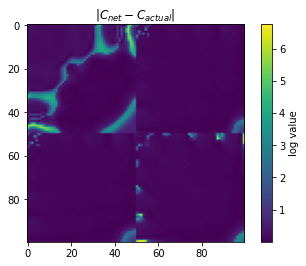

In [30]:
# Visualize the difference between generated and actual matrix
C_residual = abs(cov_predict - cov_actual)
plt.title(r"$|C_{net} - C_{actual}|$")
plt.imshow(C_residual)
cbar = plt.colorbar()
cbar.set_label("log value")

idx =  3711
0.9213174 [0.6208181  0.12779975 0.09532169 0.0438496  0.03352827]
[1423.2211  1012.5511   544.6617   339.36322  533.5592 ]


Text(0, 0.5, 'PC 2')

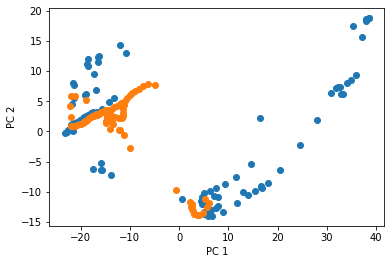

In [39]:
# do a PCA of this matrix
idx = np.random.randint(0, N_test)
print("idx = ", idx)
C_actual = test_data[idx][1].view(100, 100).detach().numpy()
features = net_2(params); C_predict = decoder(features.view(1,10)).view(100, 100).detach().numpy()

pca = PCA(n_components = 5)
pca.fit(C_actual) #<- calculates the principal axes of the given data
components = pca.transform(C_actual)
components_2 = pca.transform(C_predict)

print(np.sum(pca.explained_variance_ratio_), pca.explained_variance_ratio_)

pca_diff = np.sum(abs(components_2 - components), axis=0)
print(pca_diff)

plt.scatter(components[:,0], components[:,1])
plt.scatter(components_2[:,0], components_2[:,1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")

In [18]:
# Test for positive definite-ness
pos_diag = True
for i in range(cov_predict.shape[0]):
    if cov_predict[i,i] <= 0:
        pos_diag = False
print("diagonal is all positive:", pos_diag)

diagonal is all positive: True


tensor(0.)


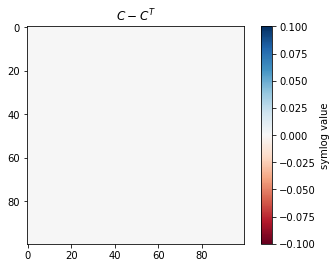

In [31]:
cov_predict2 = cov_predict.to(CovNet.try_gpu())
cov_sym = (CovNet.symmetric_exp(cov_predict2) + CovNet.symmetric_exp(torch.t(cov_predict2)))
cov_asym = (CovNet.symmetric_exp(cov_predict2) - CovNet.symmetric_exp(torch.t(cov_predict2)))
symmetric_val = torch.linalg.norm(cov_asym, 2) / torch.linalg.norm(cov_sym, 2)
print(symmetric_val)

plt.figure()
plt.title(r"$C - C^T$")
#plt.imshow(cov_test2 - cov_test2.T, cmap="RdBu")
plt.imshow(cov_asym.cpu(), cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("symlog value")

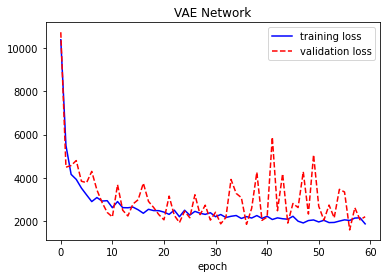

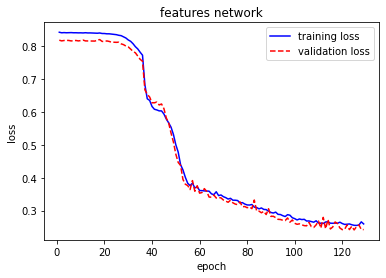

In [32]:
train_loss = torch.load(net_dir+"train_loss.dat")
valid_loss = torch.load(net_dir+"valid_loss.dat")
train_loss_f = torch.load(net_dir+"train_loss-features.dat")
valid_loss_f = torch.load(net_dir+"valid_loss-features.dat")

epoch = range(len(train_loss))
plt.title("VAE Network")
plt.plot(epoch, train_loss, color="blue", label="training loss")
plt.plot(epoch, valid_loss, color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
#plt.ylabel("loss")
#plt.ylim(800, 4000)
#plt.yscale("log")
plt.legend()

epoch_f = range(len(train_loss_f))
plt.figure()
plt.title("features network")
plt.plot(epoch_f[1:], train_loss_f[1:], color="blue", label="training loss")
plt.plot(epoch_f[1:], valid_loss_f[1:], color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.yscale("log")
plt.legend()

In [33]:
# try to visualize the feature space
features = torch.zeros(N, 10, device=CovNet.try_gpu())
t1 = time.time()
for (i, batch) in enumerate(test_loader):
    params = batch[0]; matrix = batch[1]
    z, mu, log_var = encoder(matrix.view(1, 100, 100))
    features[i] = z
    
features = features.to("cpu").detach().numpy()
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

Done!, took 0 minutes 9.69 seconds


[0.8295824  1.0219038  0.4254491  0.16733153 0.00176635 0.52402157
 0.23127827 0.49464232 0.70917827 0.87820417]


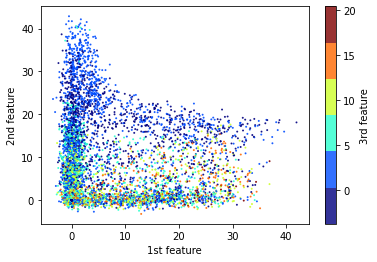

In [34]:
N_colors = 6 # <- number of colors
base = plt.cm.get_cmap("jet")
color_list = base(np.linspace(0, 1, N_colors))
cmap_name = base.name + str(N)
cmap = base.from_list(cmap_name, color_list, N_colors)

print(np.mean(features, axis=0))
f1 = 0; f2 = 1; f3 = 2
plt.scatter(features[:,f1], features[:,f2], cmap=cmap, c=features[:,f3], alpha=0.8, s=1)
plt.xlabel("1st feature")
plt.ylabel("2nd feature")
cbar = plt.colorbar()
cbar.set_label("3rd feature")

## Extra tests for debugging

Covariance matrix is NOT positive-definite!
1 [ 9.24216640e+08  4.57185440e+08  3.45549152e+08  2.00713856e+08
  1.40470880e+08  7.95024240e+07  7.45302080e+07  4.10885800e+07
  3.55686080e+07  2.38220320e+07  1.81468980e+07  1.44928190e+07
  9.77248800e+06  9.29729800e+06  6.42127050e+06  5.31957850e+06
  4.51185350e+06  3.27843550e+06  3.11896875e+06  2.37967575e+06
  1.90942788e+06  1.74812750e+06  1.34205588e+06  1.20571150e+06
  1.02206781e+06  8.35322500e+05  7.89321375e+05 -5.00642562e+05
  6.45776562e+05  5.68982062e+05  5.21911281e+05  4.33298438e+05
  4.00994188e+05  3.50148156e+05  2.99476625e+05  2.80302781e+05
  2.35199891e+05  2.19241016e+05  1.91911797e+05  1.73402812e+05
  1.58563656e+05  1.39448891e+05  1.31221812e+05  1.19167141e+05
  1.06719875e+05  1.03083938e+05  9.19162266e+04  8.37254453e+04
  8.07970078e+04  7.08451094e+04  6.75910859e+04  6.19720977e+04
  5.49492383e+04  5.45381172e+04  4.83150234e+04  4.53006289e+04
  4.32953594e+04  3.91388359e+04  3.75385273

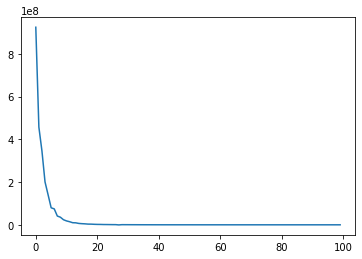

In [28]:
params_bad = torch.tensor([74.65041619539261, 0.1152447252368927, 0.0228745732113719, 3.696852154016495, 1.9854176259040832,-2.1415713782310486])
features = net_2(params_bad); C_bad = decoder(features.view(1,10)).view(100, 100)
C_bad = CovNet.corr_to_cov(C_bad).detach().numpy()

try:
    L = np.linalg.cholesky(C_bad)
except np.linalg.LinAlgError as err:
    print("Covariance matrix is NOT positive-definite!")

eigen, v = np.linalg.eig(C_bad)
print(len(eigen[(eigen < 0)]), eigen)
plt.plot(range(100), eigen)

In [39]:
# test to see what outputs from the training / validation sets looks like
# I'm only loading in a subset of the whole training set to save memory / time
t1 = time.time()
train_data = MatrixDataset(training_dir, int(N*0.1), 0, train_log, train_correlation, train_cholesky)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 22.98 s


loss =  114.20138549804688
rediction = 29.388, KL Divergence = 84.813
sample 127, params: tensor([6.7463e+01, 3.0175e-01, 1.1845e-01, 1.8676e-09, 1.9195e+00, 4.2772e-01],
       device='cuda:0')


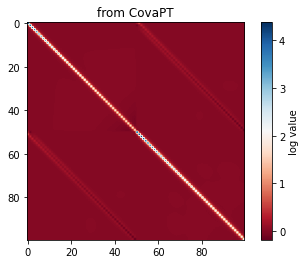

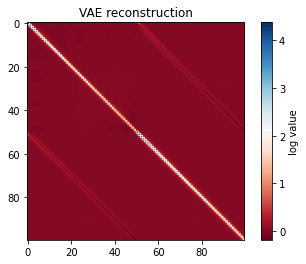

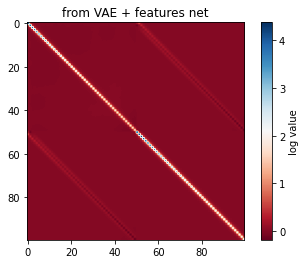

In [40]:
idx = np.random.randint(0, N*0.1)
params = train_data[idx][0]
# matrix from CovaPT
cov_actual = train_data[idx][1]

cov_VAE, mu, log_var = net(cov_actual.view(1,100,100)); cov_VAE = cov_VAE.view(100,100)
# matrix from parameters -> features and features -> matrix
features = net_2(params); cov_predict = decoder(features.view(1,10)).view(100, 100)

RLoss = F.l1_loss(cov_VAE, cov_actual, reduction="sum")
KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2))

print("loss = ", VAE_loss(cov_VAE, cov_actual, mu, log_var).item())
print("rediction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
cov_VAE = cov_VAE.to("cpu").detach(); cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(cov_VAE, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + features net")
plt.imshow(cov_predict, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

Indexes: 1328 3497


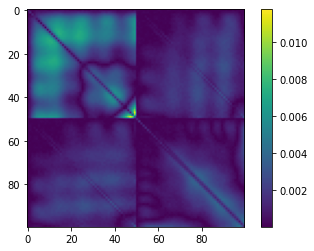

In [41]:
# Let's first test that seperate parameter imputs give different outputs
idx1 = np.random.randint(0, N*0.1); idx2 = np.random.randint(0, N*0.1)
params1 = train_data[idx1][0]; params2 = train_data[idx2][0]
cov_actual1 = train_data[idx1][1]; cov_actual2 = train_data[idx2][1]

features = net_2(params1); cov_predict1 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()
features = net_2(params2); cov_predict2 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:", idx1, idx2)
plt.imshow(abs(cov_predict1 - cov_predict2))
cbar = plt.colorbar()